<a href="https://colab.research.google.com/github/ksetdekov/test_predict_ts/blob/main/LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import sys 
import numpy as np 
from scipy.stats import randint
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns 
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler 
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline 
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SelectFromModel
from sklearn import metrics 
from sklearn.metrics import mean_squared_error,r2_score


import keras
from keras.layers import Dense
from keras.models import Sequential
from keras.utils.np_utils import to_categorical
from keras.optimizers import SGD 
from keras.callbacks import EarlyStopping
from keras.utils import np_utils
import itertools
from keras.layers import LSTM
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers import Dropout

# Считаем данные

In [2]:
data_url = 'https://raw.githubusercontent.com/ksetdekov/test_predict_ts/main/2_5350833418869411277.csv'
data = pd.read_csv(data_url)
data.date = pd.to_datetime(data.date)

data = data.set_index('date')
data.dropna(inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


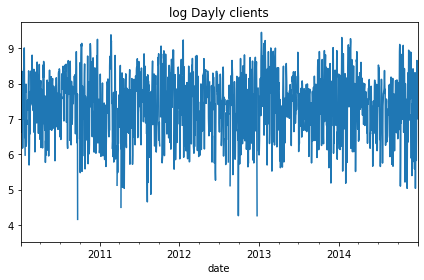

In [3]:
np.log(data.clients.resample('D').sum()).plot(title='log Dayly clients') 
plt.tight_layout()
plt.show()   

In [4]:

ts_data = data.copy()
ts_data['clients'] = np.log1p(ts_data['clients'])
ts_data['hour'] = [ts_data.index[i].hour for i in range(len(ts_data))]
ts_data['month'] = [ts_data.index[i].month for i in range(len(ts_data))]
ts_data['weekday'] = [ts_data.index[i].day for i in range(len(ts_data))]
ts_data['last_day_m'] = [ts_data.index[i].is_month_end for i in range(len(ts_data))]
ts_data['last_day_m']=ts_data['last_day_m'].astype(int)

# оконные переменные
clients_val = ts_data[["clients"]]
width = 24
shifted = clients_val.shift(width -1)
window = shifted.rolling(window=width)

new_df = pd.concat([window.min(), window.mean(), window.max()], axis=1)
new_df.columns = ['min24', 'mean24', 'max24']


width=48
shifted = clients_val.shift(width -1)
window = shifted.rolling(window=width)

new_df_2 = pd.concat([window.min(), window.mean(), window.max()], axis=1)
new_df_2.columns = ['min48', 'mean48', 'max48']

new_df_2= pd.merge(new_df_2, new_df, how='outer', on="date")
ts_data = pd.merge(ts_data, new_df_2, how='outer', on="date")

without_na_ts_data = ts_data.dropna()

without_na_ts_data.tail()

,clients,hour,month,weekday,last_day_m,min48,mean48,max48,min24,mean24,max24
date,,,,,,,,,,,
2014-12-30 19:00:00,3.583519,19,12,30,0,3.496508,5.177072,6.098074,3.044522,4.860677,5.924256
2014-12-30 20:00:00,3.295837,20,12,30,0,3.496508,5.181041,6.098074,3.044522,4.826354,5.924256
2014-12-30 21:00:00,3.044522,21,12,30,0,3.496508,5.190041,6.098074,3.044522,4.798109,5.924256
2014-12-30 22:00:00,2.197225,22,12,30,0,3.496508,5.201745,6.098074,3.044522,4.766457,5.924256
2014-12-30 23:00:00,2.833213,23,12,30,0,3.496508,5.218298,6.098074,3.044522,4.739483,5.924256


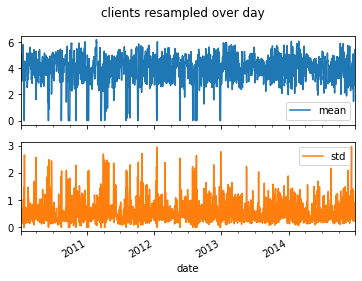

In [5]:
r = without_na_ts_data.clients.resample('D').agg(['mean', 'std'])
r.plot(subplots = True, title='clients resampled over day')
plt.show()

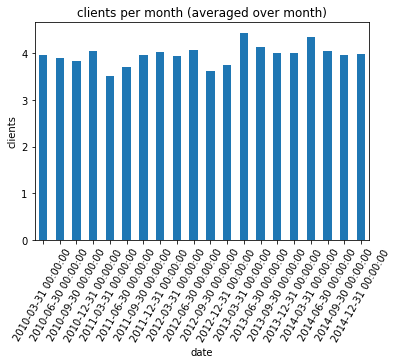

In [6]:
# сумма клиентов по месяцам
without_na_ts_data['clients'].resample('Q').mean().plot(kind='bar')
plt.xticks(rotation=60)
plt.ylabel('clients')
plt.title('clients per month (averaged over month)')
plt.show()

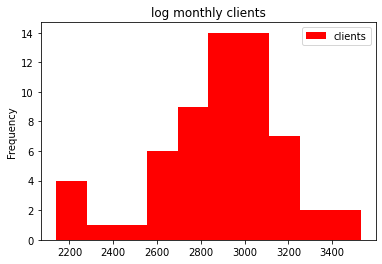

In [7]:
(without_na_ts_data.clients.resample('M').sum()).plot(title='log monthly clients', kind='hist', color='r', legend=True ) 


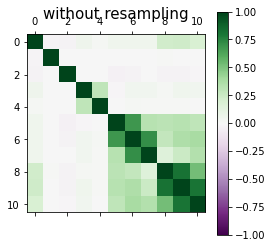

In [8]:
# корреляция между факторами
plt.matshow(without_na_ts_data.corr(method='spearman'),vmax=1,vmin=-1,cmap='PRGn')
plt.title('without resampling', size=15)
plt.colorbar()
plt.show()

In [9]:
without_na_ts_data.columns

Index(['clients', 'hour', 'month', 'weekday', 'last_day_m', 'min48', 'mean48',
       'max48', 'min24', 'mean24', 'max24'],
      dtype='object')

In [10]:
without_na_ts_data

,clients,hour,month,weekday,last_day_m,min48,mean48,max48,min24,mean24,max24
date,,,,,,,,,,,
2010-01-05 22:00:00,4.204693,22,1,5,0,3.988984,4.672544,5.204007,3.044522,3.433209,4.382027
2010-01-05 23:00:00,3.931826,23,1,5,0,3.988984,4.662430,5.204007,3.044522,3.393708,4.077537
2010-01-06 00:00:00,4.043051,0,1,6,0,3.988984,4.643130,5.204007,3.044522,3.371950,3.555348
2010-01-06 01:00:00,4.356709,1,1,6,0,3.258097,4.605274,5.204007,3.044522,3.375038,3.555348
2010-01-06 02:00:00,3.931826,2,1,6,0,3.258097,4.565520,5.141664,3.044522,3.373465,3.555348
...,...,...,...,...,...,...,...,...,...,...,...
2014-12-30 19:00:00,3.583519,19,12,30,0,3.496508,5.177072,6.098074,3.044522,4.860677,5.924256
2014-12-30 20:00:00,3.295837,20,12,30,0,3.496508,5.181041,6.098074,3.044522,4.826354,5.924256
2014-12-30 21:00:00,3.044522,21,12,30,0,3.496508,5.190041,6.098074,3.044522,4.798109,5.924256


финальный вывод - не брать факторы из 24 часов, взять минимум и максимум за 48 часов и все факторы времени

In [11]:
better_list = without_na_ts_data[['clients', 'hour', 'month', 'weekday', 'last_day_m', 'min48', 
       'max48']]
better_list.tail()

,clients,hour,month,weekday,last_day_m,min48,max48
date,,,,,,,
2014-12-30 19:00:00,3.583519,19,12,30,0,3.496508,6.098074
2014-12-30 20:00:00,3.295837,20,12,30,0,3.496508,6.098074
2014-12-30 21:00:00,3.044522,21,12,30,0,3.496508,6.098074
2014-12-30 22:00:00,2.197225,22,12,30,0,3.496508,6.098074
2014-12-30 23:00:00,2.833213,23,12,30,0,3.496508,6.098074


In [12]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	dff = pd.DataFrame(data)
	cols, names = list(), list()
	# входные данные (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(dff.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# прогнозируемые данные (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(dff.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg
 

## LSTM prep

In [13]:
values = better_list.values
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# reframed = series_to_supervised(scaled, 24, 1)

reframed = series_to_supervised(scaled, 1, 1)

reframed

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var1(t),var2(t),var3(t),var4(t),var5(t),var6(t),var7(t)
1,0.609134,0.956522,0.0,0.133333,0.0,0.682970,0.753904,0.569603,1.000000,0.0,0.133333,0.0,0.682970,0.753904
2,0.569603,1.000000,0.0,0.133333,0.0,0.682970,0.753904,0.585717,0.000000,0.0,0.166667,0.0,0.682970,0.753904
3,0.585717,0.000000,0.0,0.166667,0.0,0.682970,0.753904,0.631156,0.043478,0.0,0.166667,0.0,0.557832,0.753904
4,0.631156,0.043478,0.0,0.166667,0.0,0.557832,0.753904,0.569603,0.086957,0.0,0.166667,0.0,0.557832,0.744873
5,0.569603,0.086957,0.0,0.166667,0.0,0.557832,0.744873,0.551471,0.130435,0.0,0.166667,0.0,0.557832,0.744873
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43677,0.634824,0.782609,1.0,0.966667,0.0,0.598651,0.883428,0.519144,0.826087,1.0,0.966667,0.0,0.598651,0.883428
43678,0.519144,0.826087,1.0,0.966667,0.0,0.598651,0.883428,0.477468,0.869565,1.0,0.966667,0.0,0.598651,0.883428
43679,0.477468,0.869565,1.0,0.966667,0.0,0.598651,0.883428,0.441060,0.913043,1.0,0.966667,0.0,0.598651,0.883428
43680,0.441060,0.913043,1.0,0.966667,0.0,0.598651,0.883428,0.318312,0.956522,1.0,0.966667,0.0,0.598651,0.883428


In [14]:
# reframed.drop(reframed.columns[[169,170,171,172,173,174]], axis=1, inplace=True)
reframed.drop(reframed.columns[[8,9,10,11,12,13]], axis=1, inplace=True)

reframed.head()

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var1(t)
1,0.609134,0.956522,0.0,0.133333,0.0,0.682970,0.753904,0.569603
2,0.569603,1.000000,0.0,0.133333,0.0,0.682970,0.753904,0.585717
3,0.585717,0.000000,0.0,0.166667,0.0,0.682970,0.753904,0.631156
4,0.631156,0.043478,0.0,0.166667,0.0,0.557832,0.753904,0.569603
5,0.569603,0.086957,0.0,0.166667,0.0,0.557832,0.744873,0.551471


In [16]:
values = reframed.values
n_train_time = values.shape[0]-365*24
train = values[:n_train_time, :]
test = values[n_train_time:, :]

# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
# train_X = train_X.reshape((train_X.shape[0], 24, 7))
# test_X = test_X.reshape((test_X.shape[0], 24, 7))
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape) 
# We reshaped the input into the 3D format as expected by LSTMs, namely [samples, timesteps, features].

(34921, 1, 7) (34921,) (8760, 1, 7) (8760,)


Epoch 1/40
175/175 - 21s - loss: 0.0418 - val_loss: 0.0107
Epoch 2/40
175/175 - 2s - loss: 0.0101 - val_loss: 0.0047
Epoch 3/40
175/175 - 2s - loss: 0.0066 - val_loss: 0.0041
Epoch 4/40
175/175 - 2s - loss: 0.0062 - val_loss: 0.0041
Epoch 5/40
175/175 - 2s - loss: 0.0061 - val_loss: 0.0041
Epoch 6/40
175/175 - 2s - loss: 0.0060 - val_loss: 0.0041
Epoch 7/40
175/175 - 2s - loss: 0.0060 - val_loss: 0.0041
Epoch 8/40
175/175 - 2s - loss: 0.0059 - val_loss: 0.0041
Epoch 9/40
175/175 - 2s - loss: 0.0059 - val_loss: 0.0041
Epoch 10/40
175/175 - 2s - loss: 0.0059 - val_loss: 0.0041
Epoch 11/40
175/175 - 2s - loss: 0.0059 - val_loss: 0.0041
Epoch 12/40
175/175 - 2s - loss: 0.0060 - val_loss: 0.0041
Epoch 13/40
175/175 - 2s - loss: 0.0059 - val_loss: 0.0041
Epoch 14/40
175/175 - 2s - loss: 0.0059 - val_loss: 0.0041
Epoch 15/40
175/175 - 2s - loss: 0.0058 - val_loss: 0.0041
Epoch 16/40
175/175 - 2s - loss: 0.0059 - val_loss: 0.0042
Epoch 17/40
175/175 - 2s - loss: 0.0059 - val_loss: 0.0041
Epoch

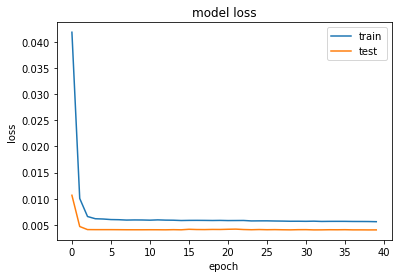

Test RMSE: 0.439


In [17]:
model = Sequential()
model.add(LSTM(200, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')



# fit network
history = model.fit(train_X, train_y, epochs=40, batch_size=200, validation_data=(test_X, test_y), verbose=2, shuffle=False)

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], 7))
# invert scaling for forecast
inv_yhat = np.concatenate((yhat, test_X[:, -6:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X[:, -6:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

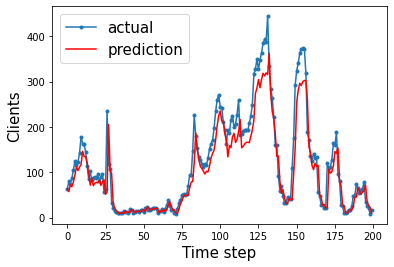

In [18]:
## time steps, every step is one hour 

aa=[x for x in range(200)]
plt.plot(aa, np.expm1(inv_y[-200:]), marker='.', label="actual")
plt.plot(aa, np.expm1(inv_yhat[-200:]), 'r', label="prediction")
plt.ylabel('Clients', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show()
